In [9]:
#data: https://www.kaggle.com/datasets/biaiscience/dogs-vs-cats
import os
import glob
 
data_dir = './catVsdog'
training_dir = os.path.join(data_dir,'train')
if not os.path.isdir(training_dir):
    os.mkdir(training_dir)

dog_training_dir = os.path.join(training_dir,'dog')
if not os.path.isdir(dog_training_dir):
  os.mkdir(dog_training_dir)

#create cat in training
cat_training_dir = os.path.join(training_dir,"cat")
if not os.path.isdir(cat_training_dir):
  os.mkdir(cat_training_dir)

#create validation dir
validation_dir = os.path.join(data_dir,"validation")
if not os.path.isdir(validation_dir):
  os.mkdir(validation_dir)

#create dog in validation
dog_validation_dir = os.path.join(validation_dir,"dog")
if not os.path.isdir(dog_validation_dir):
  os.mkdir(dog_validation_dir)

#create cat in validation
cat_validation_dir = os.path.join(validation_dir,"cat")
if not os.path.isdir(cat_validation_dir):
  os.mkdir(cat_validation_dir)


In [10]:
import shutil

split_size = 0.8
cat_imgs_size = len(glob.glob('./catVsdog/train/cat*'))
dog_imgs_size = len(glob.glob('./catVsdog/train/dog*'))

for i,img in enumerate(glob.glob("./catVsdog/train/cat*")):
  if i < (cat_imgs_size * split_size):
    shutil.move(img,cat_training_dir)
  else:
    shutil.move(img,cat_validation_dir)

for i,img in enumerate(glob.glob("./catVsdog/train/dog*")):
  if i < (dog_imgs_size * split_size):
    shutil.move(img,dog_training_dir)
  else:
    shutil.move(img,dog_validation_dir)

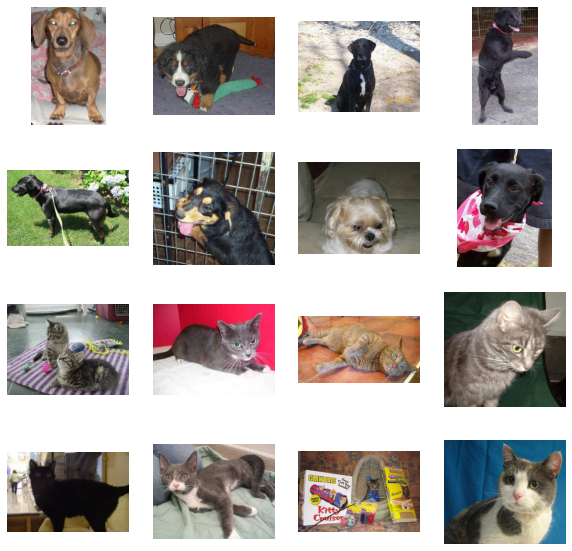

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.core.pylabtools import figsize

samples_dog = [os.path.join(dog_training_dir,np.random.choice(os.listdir(dog_training_dir),1)[0]) for _ in range(8)]
samples_cat = [os.path.join(cat_training_dir,np.random.choice(os.listdir(cat_training_dir),1)[0]) for _ in range(8)]

nrows = 4
ncols = 4

fig, ax = plt.subplots(nrows,ncols,figsize = (10,10))
ax = ax.flatten()

for i in range(nrows*ncols):
  if i < 8:
    pic = plt.imread(samples_dog[i%8])
    ax[i].imshow(pic)
    ax[i].set_axis_off()
  else:
    pic = plt.imread(samples_cat[i%8])
    ax[i].imshow(pic)
    ax[i].set_axis_off()
plt.show()



In [12]:
import torch
import torchvision
from torchvision import datasets, transforms

traindir = './catVsdog/train'
testdir = './catVsdog/validation'

data_transforms = transforms.Compose([transforms.Resize((224,224)),
                                    transforms.ToTensor(),
                                    torchvision.transforms.Normalize(mean= [0.485,0.456,0.406],std=[0.229, 0.224, 0.225],
                                    ),])

train_data = datasets.ImageFolder(traindir,transform=data_transforms)
test_data = datasets.ImageFolder(testdir,transform=data_transforms)

trainloader = torch.utils.data.DataLoader(train_data, shuffle = True, batch_size=16)
testloader = torch.utils.data.DataLoader(test_data, shuffle = True, batch_size=16)

In [13]:
def make_train_step(model, optimizer, loss_fn):
  def train_step(x,y):
    #make prediction
    yhat = model(x)
    #enter train mode
    model.train()
    #compute loss
    loss = loss_fn(yhat,y)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    #optimizer.cleargrads()

    return loss
  return train_step



In [14]:
from torchvision import datasets, models, transforms
import torch.nn as nn

device = 'mps' if torch.backends.mps.is_available() else 'cpu'

model = models.resnet18(pretrained=True)
for params in model.parameters():
    params.requires_grad_=False

nr_filtrs = model.fc.in_features
model.fc = nn.Linear(nr_filtrs,1)
model = model.to(device)

In [15]:
from torch.nn.modules.loss import BCEWithLogitsLoss
from torch.optim import lr_scheduler

#loss
loss_fn = BCEWithLogitsLoss() #binary cross entropy with sigmoid, so no need to use sigmoid in the model

#optimizer
optimizer = torch.optim.Adam(model.fc.parameters()) 

#train step
train_step = make_train_step(model, optimizer, loss_fn)


In [16]:
from tqdm import tqdm

losses= []
val_losses = []

epoch_train_losses = []
epoch_test_losses = []

n_epochs = 5
early_stopping_tolerance = 3
early_stopping_threshold = 0.03

for epoch in range(n_epochs):
    epoch_loss = 0
    for i, data in tqdm(enumerate(trainloader), total= len(trainloader)):
        x_batch, y_batch = data
        x_batch = x_batch.to(device)
        y_batch = y_batch.unsqueeze(1).float()
        y_batch = y_batch.to(device)
        loss = train_step(x_batch, y_batch)
        epoch_loss += loss/len(trainloader)
    
    epoch_train_losses.append(epoch_loss)
    print('\nEpoch: [], train loss : {}'.format(epoch+1, epoch_loss))

    with torch.no_grad():
        cum_loss = 0
        for x_batch, y_batch in testloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.unsqueeze(1).float() #convert target to same nn output shape
            y_batch = y_batch.to(device)

            #model to eval mode
            model.eval()
            yhat = model(x_batch)
            val_loss = loss_fn(yhat,y_batch)
            cum_loss += loss/len(testloader)
            val_losses.append(val_loss.item())

    epoch_test_losses.append(cum_loss)
    print('Epoch : {}, val loss : {}'.format(epoch+1,cum_loss))  
    best_loss = min(epoch_test_losses)

    if cum_loss <= best_loss:
        best_model_wts = model.state_dict()
    
    early_stopping_counter = 0
    if cum_loss > best_loss:
      early_stopping_counter +=1

    if (early_stopping_counter == early_stopping_tolerance) or (best_loss <= early_stopping_threshold):
      print("/nTerminating: early stopping")
      break #terminate training
    
#load best model
model.load_state_dict(best_model_wts)
    







100%|██████████| 1250/1250 [05:14<00:00,  3.97it/s]



Epoch: [], train loss : 1
Epoch : 1, val loss : 0.011414425447583199
/nTerminating: early stopping


<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction : Dog


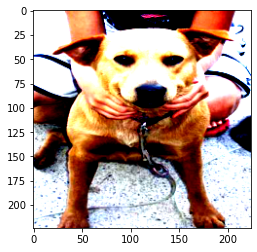

In [19]:
import matplotlib.pyplot as plt 

def inference(test_data):
  idx = torch.randint(1, len(test_data), (1,))
  sample = torch.unsqueeze(test_data[idx][0], dim=0).to(device)

  if torch.sigmoid(model(sample)) < 0.5:
    print("Prediction : Cat")
  else:
    print("Prediction : Dog")


  plt.imshow(test_data[idx][0].permute(1, 2, 0))

inference(test_data)